In [429]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
# Importamos utilidades y modelos de sklearn
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor

In [392]:
# Métrica de evaluación
def RMSLE(actual, pred):
    return (np.mean((np.log(actual + 1) - np.log(pred + 1)) ** 2)) **.5

def normailize_df(refDf, train):
    df = refDf.copy()
    df['año'] = df['fecha'].dt.year
    df['antiguedad'] = df['antiguedad'] + (2016 - df['año']) # Se normaliza la antiguedad.
    df.drop(["direccion", 'descripcion', 'lat', 'lng', 'fecha'], axis=1, inplace=True)
    
    nulltotales = df[df['metrostotales'].isnull()]
    nullcubiertos = df[df['metroscubiertos'].isnull()]
    notnullapart = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] < df['metroscubiertos'])]
    notnullapart2 = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] > df['metroscubiertos'])]
    notnullapart3 = df[(~ df['metrostotales'].isnull()) & (df['metrostotales'] == df['metroscubiertos'])]
 
    df['habitable'] = False
    tipodepropiedades = df.tipodepropiedad.cat.categories.to_list()
    for tipodepropiedad in tipodepropiedades: 

        idsNullMetrosTotales = (df.tipodepropiedad == tipodepropiedad) & (df.metrostotales.isnull())
        idsNullMetrosCubiertos = (df.tipodepropiedad == tipodepropiedad) & (df.metroscubiertos.isnull())
        banos = df[df.tipodepropiedad == tipodepropiedad].banos.mode(dropna=False);
        habitaciones = df[df.tipodepropiedad == tipodepropiedad].habitaciones.mode(dropna=False);

        ## Verificamos si la cantidad de registros con metros cubiertos nulos es mayor a 2/5 de los totales. Si es asi 
        ## los consideramos propiedades no habitables. Y los tratamos de manera diferente
        if(len(nullcubiertos[nullcubiertos.tipodepropiedad == tipodepropiedad]) >= 2/5* len(df[df.tipodepropiedad == tipodepropiedad])):
            df.metrostotales.fillna(0, inplace=True)
            df.metroscubiertos.fillna(0, inplace=True)
        else:
            df[idsNullMetrosTotales]['metrostotales'] =  df[idsNullMetrosTotales]['metroscubiertos']
            df[idsNullMetrosCubiertos]['metroscubiertos'] =  df[idsNullMetrosCubiertos]['metrostotales']

        #Si la moda del tipo de propiedad de banos y habitaciones son ambas distintas de nan entonces la propiedad es habitable.

        df.loc[(df.tipodepropiedad == tipodepropiedad), 'habitable'] = not(numpy.isnan(banos[0]) and numpy.isnan(habitaciones[0]))
    
    df['metros'] = df['metrostotales'] + df['metroscubiertos']
    if(train):
        def is_outlier(group):
            Q1 = group.quantile(0.25)
            Q3 = group.quantile(0.75)
            IQR = Q3 - Q1
            precio_min = Q1 - 1.5 * IQR
            precio_max = Q3 + 1.5 * IQR
            return ~group.between(precio_min, precio_max)
        df['precio_mt2'] = df['precio'] / df['metros']
        print()
        
        df = df[~df.groupby('tipodepropiedad')['precio_mt2'].apply(is_outlier).fillna(False)]
        print('Despues de filtrar: ', df.shape)
    return df

In [440]:
df_train = pd.read_csv('train.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])
df_test = pd.read_csv('test.csv',
        index_col='id',
        dtype={'gimnasio': int,
                'usosmultiples': int,
                'escuelascercanas': int,
                'piscina': int,
                'centroscomercialescercanos': int,
                'tipodepropiedad': 'category',
                'provincia': 'category',
                'ciudad': 'category'
            },
        parse_dates=['fecha'])

df_train = normailize_df(df_train, True)
df_test = normailize_df(df_test, False)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Despues de filtrar:  (223477, 21)


In [441]:

df_train['metros'] = df_train['metrostotales'] + df_train['metroscubiertos']
df_test['metros'] = df_test['metrostotales'] + df_test['metroscubiertos']


tipodepropiedades = df_train.tipodepropiedad.cat.categories.to_list()


def predict_by_prop(idsTrainFil, idsTestFil): 
    for tipodepropiedad in tipodepropiedades: 
        #Solo las propiedades que queremos
        idsTrain = (df_train.tipodepropiedad == tipodepropiedad) & idsTrainFil
        idsTest = (df_test.tipodepropiedad == tipodepropiedad) & idsTestFil
        trainDf = df_train[idsTrain].groupby(['antiguedad']).agg(precio_mt2=('precio_mt2', 'median')).reset_index()

        X = trainDf[['antiguedad']]
        y = trainDf['precio_mt2']
#         print('------', tipodepropiedad)
#         print(X.shape, len(y))
        if(len(y) == 0 or len(df_test[idsTest][['antiguedad']]) == 0): 
            continue
        if(len(y) == 1):
    #         print(        df_test[df_test.tipodepropiedad == tipodepropiedad, 'target'])
            df_test.loc[df_test.tipodepropiedad == tipodepropiedad, 'target'] = y.to_list()[0]
            continue

#         linear_model = Ridge(alpha=0.5).fit(X, y)
        linear_model = make_pipeline(PolynomialFeatures(degree=3), Ridge())
        linear_model.fit(X, y)

        pred = linear_model.predict(df_test[idsTest][['antiguedad']])

        df_test.loc[idsTest, 'target'] = pred

        

imp = Imputer(strategy='most_frequent')
df_train['antiguedad'] = imp.fit_transform(df_train[['antiguedad']])        
df_test['antiguedad'] = imp.transform(df_test[['antiguedad']])

dfAntiguedadMenor10Train = (df_train["antiguedad"] < 10)
dfAntiguedadMenor10Test = (df_test["antiguedad"] < 10)

dfAntiguedadMayor10Train = (df_train["antiguedad"] >= 10) & (df_train["antiguedad"] < 40)
dfAntiguedadMayor10Test = (df_test["antiguedad"] >= 10) & (df_test["antiguedad"] < 40)

dfAntiguedadMayor40Train = (df_train["antiguedad"] >= 40)
dfAntiguedadMayor40Test = (df_test["antiguedad"] >= 40)

predict_by_prop(dfAntiguedadMenor10Train, dfAntiguedadMenor10Test)

predict_by_prop(dfAntiguedadMayor10Train, dfAntiguedadMayor10Test)

predict_by_prop(dfAntiguedadMayor40Train, dfAntiguedadMayor40Test)


df_test.loc[df_test.target.isnull(), 'target'] = df_test['target'].median()
df_test['target'] = df_test['target'] *  df_test['metros']
final_prediction = df_test.copy().drop(df_test.columns.difference(['target']), 1)
# # print()
final_prediction.to_csv('prediction.csv')
df_test[df_test['target'].isnull()]



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,titulo,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,año,habitable,metros,target
id,,,,,,,,,,,,,,,,,,,,


(151879, 21)


Text(0.5, 1.05, 'Regresión del costo m2 según tipo de propiedad en base a la antigüedad \n (Ultimos 10 años)')

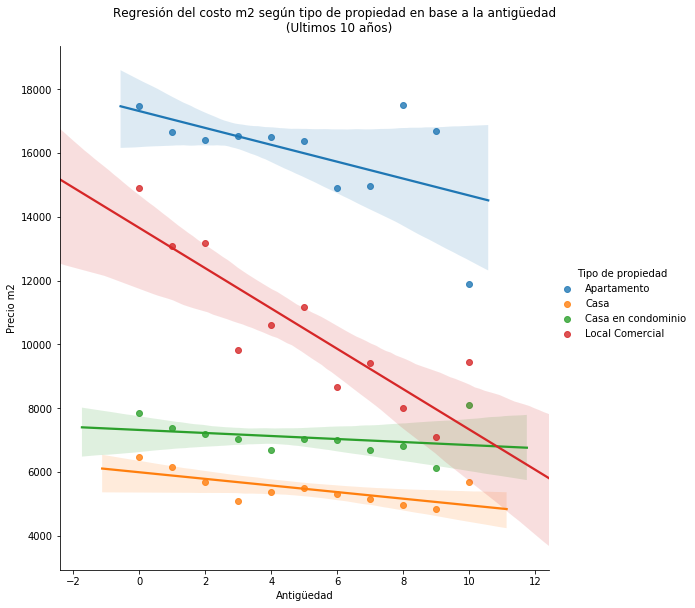

In [443]:
habitables = ['Casa', 'Casa en condominio', 'Apartamento', 'Local Comercial']
dfAntiguedad = df_train[(~ df_train["antiguedad"].isnull()) & (df_train["antiguedad"] <= 10) & (df_train["tipodepropiedad"].isin(habitables)) ]
print(dfAntiguedad.shape)
# dfAntiguedad.tipodepropiedad.value_counts()
dfAntiguedad['tipodepropiedad'].cat.remove_unused_categories(inplace=True)
dfAntiguedad = dfAntiguedad.groupby(['antiguedad', 'tipodepropiedad']).agg(prom_precio_mt2=('precio_mt2', 'mean')).reset_index()


ax = sns.lmplot(x="antiguedad", y="prom_precio_mt2", data=dfAntiguedad, hue="tipodepropiedad", height=8, order=1);

ax.set(xlabel='Antigüedad', ylabel='Precio m2')

new_title = 'Tipo de propiedad'
ax._legend.set_title(new_title)
ax.fig.suptitle('Regresión del costo m2 según tipo de propiedad en base a la antigüedad \n (Ultimos 10 años)', y= 1.05)


In [442]:
tipodepropiedades = df_train.tipodepropiedad.cat.categories.to_list()

df_test2 = df_train.copy()

def predict_by_prop(idsTrainFil, idsTestFil): 
    for tipodepropiedad in tipodepropiedades: 
        #Solo las propiedades que queremos
        idsTrain = (df_train.tipodepropiedad == tipodepropiedad) & idsTrainFil
        idsTest = (df_test2.tipodepropiedad == tipodepropiedad) & idsTestFil
        trainDf = df_train[idsTrain].groupby(['antiguedad']).agg(precio_mt2=('precio_mt2', 'median')).reset_index()

        X = trainDf[['antiguedad']]
        y = trainDf['precio_mt2']
#         print('------', tipodepropiedad)
#         print(X.shape, len(y))
        if(len(y) == 0 or len(df_test2[idsTest][['antiguedad']]) == 0): 
            continue
        if(len(y) == 1):
    #         print(        df_test[df_test.tipodepropiedad == tipodepropiedad, 'target'])
            df_test2.loc[df_test2.tipodepropiedad == tipodepropiedad, 'target'] = y.to_list()[0]
            continue

#         linear_model = Ridge(alpha=0.5).fit(X, y)
        linear_model = make_pipeline(PolynomialFeatures(degree=3), Ridge())
        linear_model.fit(X, y)

        pred = linear_model.predict(df_test2[idsTest][['antiguedad']])

        df_test2.loc[idsTest, 'target'] = pred


imp = Imputer(strategy='most_frequent')
df_train['antiguedad'] = imp.fit_transform(df_train[['antiguedad']])        
df_test2['antiguedad'] = imp.transform(df_train[['antiguedad']])

dfAntiguedadMenor10Train = (df_train["antiguedad"] < 10)
dfAntiguedadMenor10Test = (df_test2["antiguedad"] < 10)

dfAntiguedadMayor10Train = (df_train["antiguedad"] >= 10) & (df_train["antiguedad"] < 40)
dfAntiguedadMayor10Test = (df_test2["antiguedad"] >= 10) & (df_test2["antiguedad"] < 40)

dfAntiguedadMayor40Train = (df_train["antiguedad"].isnull())
dfAntiguedadMayor40Test = (df_test2["antiguedad"].isnull()) | (df_test2["antiguedad"] >= 40)

predict_by_prop(dfAntiguedadMenor10Train, dfAntiguedadMenor10Test)

predict_by_prop(dfAntiguedadMayor10Train, dfAntiguedadMayor10Test)

predict_by_prop(dfAntiguedadMayor40Train, dfAntiguedadMayor40Test)

linear_rmsle_train = RMSLE(df_train['precio_mt2'], df_test2['target'])
print(f"RMSLE Linear Regression (train): {linear_rmsle_train:.5f}")


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


RMSLE Linear Regression (train): 0.52455
